**COMBATING CYBERBULLYING WITH ML TECHNIQUES**

---



**Data Exploration and pre-preprocessing**





The data we will be using is a dataset featured on Kaggle for the Jigsaw/Conversation AI Toxic Comment Classification Challenge. The data instances are a mix of labeled and unlabeled comments from Wikipedia’s talk page edits; data instances are containted within the "comment_text" column, and possible labels given to us by the dataset are as follows: "toxic", "severe_toxic", "obscene", "threat", "insult", and "identity_hate". As such, this is a multi-label classification problem, with binary values assigned to the columns; a 1 under a column signifies that the label applies to the comment, and a 0 signifies that the label does not apply. For example, a certain comment may have 1's for column values under "toxic" and "obscene", and 0's under all other columns, signifying that the comment is both toxic and obscene.






Initial setup and Google drive mounting

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 21.0 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 462 kB 76.0 MB/s 
     |████████████████████████████████| 5.8 MB 70.3 MB/s 
     |████████████████████████████████| 1.4 MB 66.7 MB/s 
     |████████████████████████████████| 1.8 MB 20.1 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 62.6 MB/s 
     |████████████████████████████████| 352 kB 76.1 MB/s 
     |████████████████████████████████| 118 kB 78.1 MB/s 
     |████████████████████████████████| 238 kB 74.2 MB/s 
     |████████████████████████████████| 1.3 MB 61.9 MB/s 


In [2]:
from google.colab import drive
drive.mount("/content/drive")
import os
import sys
sys.path.append("/drive/MyDrive/CS7641ML_teamproject")
path = "./drive/MyDrive/CS7641ML_teamproject/jigsaw-toxic-comment-classification-challenge/"

Mounted at /content/drive


In [3]:
!python -m nltk.downloader stopwords
!python -m nltk.downloader wordnet

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /root/nltk_data...


Install required packages and environment setups

In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns

import gc
import time
import warnings

from imageio import imread
from scipy import sparse
import scipy.stats as ss

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib_venn as venn

import string
import re
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

tf.get_logger().setLevel('ERROR')

start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline


# **DATASET**

In [5]:
train=pd.read_csv(path + "train.csv")
test=pd.read_csv(path + "test.csv")
test_label = pd.read_csv(path + 'test_labels.csv')

train.head(5)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [7]:
#Shape
print(train.shape)

(159571, 8)


Observations from the dataset: there are 159571 datapoints with 8 columns each

In [8]:
x = train.iloc[:, 2:].sum()
train['non-toxic'] = (train.iloc[:,2:].sum(axis=1)==0)
print("Total : ", len(train))
print("Total non-toxic comments : ", train['non-toxic'].sum())
print("Ratio of non-toxic comments: ", train['non-toxic'].sum() *100/len(train))
print("Total labels : ", x.sum())

Total :  159571
Total non-toxic comments :  143346
Ratio of non-toxic comments:  89.83211235124176
Total labels :  35098


**Note:** As we can see in the above cell, The ratio of non-toxic-comments is **89.83%** in training dataset, therefore the dataset is more biased!

Let's visualize the data

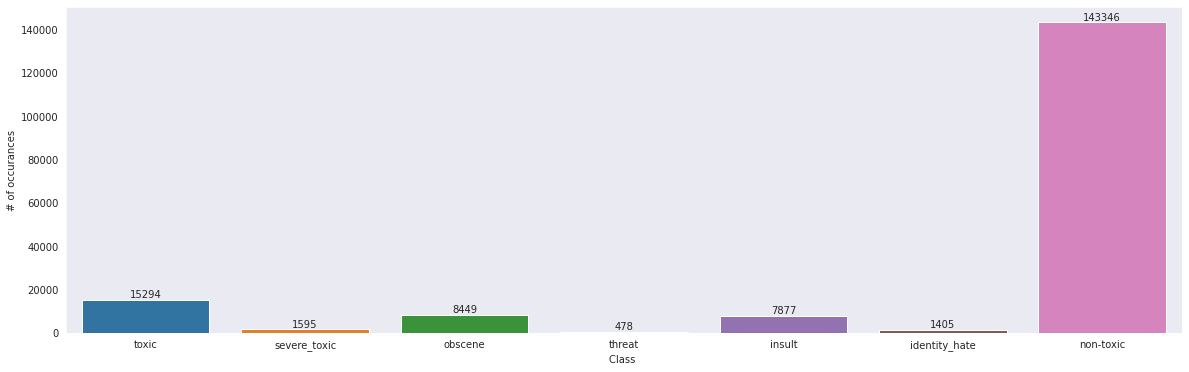

In [9]:
x = train.iloc[:,2:].sum()
plt.figure(figsize=(20,6))
ax = sns.barplot(x = x.index, y = x.values)
plt.ylabel('# of occurances', fontsize=10)
plt.xlabel('Class ', fontsize=10)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

Datapoints having multiple tags:

In [10]:
temp_df = train.iloc[:,2:-1]
mats = []
for col in temp_df.columns[1:]:
    mat = pd.crosstab(temp_df["toxic"], temp_df[col])
    mats.append(mat)
mats = pd.concat(mats, axis=1, keys=temp_df.columns[1:])
mats

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

Augumenting toxic=1 if a comment is obscene/threat/...

In [11]:
train.loc[(train['severe_toxic']==1) | (train['obscene']==1) | (train['threat']==1) | (train['insult']==1) | (train['identity_hate']==1), 'toxic']=1

In [12]:
temp_df = train.iloc[:,2:-1]
mats = []
for col in temp_df.columns[1:]:
    mat = pd.crosstab(temp_df["toxic"], temp_df[col])
    mats.append(mat)
mats = pd.concat(mats, axis=1, keys=temp_df.columns[1:])
mats

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  143346     0  143346     0  143346    0  143346     0   
1                   14630  1595    7776  8449   15747  478    8348  7877   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   143346     0  
1                    14820  1405

In [13]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.101679,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.302226,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Of the comments that do have label values assigned, we observed the following distribution:

In [14]:
cols = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']
print(train[cols].sum())

obscene           8449
insult            7877
toxic            16225
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


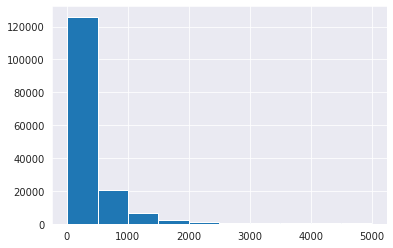

In [15]:
train['length'] = train['comment_text'].apply(lambda x: len(str(x)))
train['length'].hist()
plt.show()

# *Data Cleaning*

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"_", "", text)               # remove _
    text = re.sub(' {2, }', ' ', text)          # 2+ spaces -> 1 space
    text = re.sub(r'(\n(\s)*){2,}', '\n', text) # multi new lines -> 1 new line
    text = re.sub(r"\d+", "", text)             # remove numbers
    text = text.strip(' ')
    return text


In [17]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))

In [18]:
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))

Cleaned comments:

In [19]:
train['comment_text'].head(10)

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i am s...
2    hey man i am really not trying to edit war it ...
3    more i cannot make any real suggestions on imp...
4    you sir are my hero any chance you remember wh...
5    congratulations from me as well use the tools ...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense was offensive to yo...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [20]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic,length
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,True,264
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,True,112
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,True,233
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,True,622
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,True,67
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0,True,65
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0,False,44
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0,True,115
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,True,472
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,True,70


In [21]:
test['comment_text'].head(10)

0    yo bitch ja rule is more succesful then you wi...
1              from rfc the title is fine as it is imo
2                       sources zawe ashton on lapland
3    if you have a look back at the source the info...
4            i do not anonymously edit articles at all
5    thank you for understanding i think very highl...
6    please do not add nonsense to wikipedia such e...
7                       dear god this site is horrible
8    only a fool can believe in such numbers the co...
9    double redirects when fixing double redirects ...
Name: comment_text, dtype: object

In [22]:
test.head(10)

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i do not anonymously edit articles at all
5,0001ea8717f6de06,thank you for understanding i think very highl...
6,00024115d4cbde0f,please do not add nonsense to wikipedia such e...
7,000247e83dcc1211,dear god this site is horrible
8,00025358d4737918,only a fool can believe in such numbers the co...
9,00026d1092fe71cc,double redirects when fixing double redirects ...


Using stop words

In [23]:
stop_words = set(stopwords.words('english'))

In [24]:
train['comment_text'] = train['comment_text'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [25]:
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic,length
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,True,264
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,True,112
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,True,233
3,0001b41b1c6bb37e,cannot make real suggestions improvement wonde...,0,0,0,0,0,0,True,622
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,True,67


In [26]:
test['comment_text'] = test['comment_text'].map(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [27]:
test.head(5)

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,sources zawe ashton lapland
3,00017563c3f7919a,look back source information updated correct f...
4,00017695ad8997eb,anonymously edit articles


In [28]:
print(train.shape)

(159571, 10)


In [29]:
print(test.shape)

(153164, 2)


# Encoding

Using TF-IDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:

from sklearn.feature_extraction.text import TfidfVectorizer
import re
stops = stopwords.words('english')
x = train.comment_text
vectorizer = TfidfVectorizer(stop_words=stops, lowercase=True)
comment_matrix = vectorizer.fit_transform(x)

In [32]:
# encode document
vectorizer.get_feature_names_out()[200:250]


array(['abbassed', 'abbassi', 'abbassid', 'abbastanza', 'abbau', 'abbd',
       'abbe', 'abberations', 'abberline', 'abberrant', 'abbes',
       'abbetting', 'abbey', 'abbeymaynard', 'abbeys', 'abbf', 'abbi',
       'abbie', 'abbitt', 'abbled', 'abbles', 'abbot', 'abbott',
       'abbottabad', 'abbottsford', 'abbr', 'abbrasive', 'abbrev',
       'abbrevation', 'abbreveated', 'abbreviate', 'abbreviated',
       'abbreviatedis', 'abbreviates', 'abbreviating', 'abbreviation',
       'abbreviations', 'abbrevs', 'abbriviations', 'abbrégé', 'abbs',
       'abbusively', 'abby', 'abbyses', 'abbythecat', 'abbywinters',
       'abbás', 'abc', 'abcd', 'abcde'], dtype=object)

In [33]:
comment_matrix[0]

<1x176312 sparse matrix of type '<class 'numpy.float64'>'
	with 23 stored elements in Compressed Sparse Row format>

In [34]:
comment_matrix.shape

(159571, 176312)

**Dimensionality reduction using truncated SVD (aka LSA).**

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with **sparse matrices efficiently.**

In [35]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from scipy.spatial import distance
from numpy.ma.core import ceil
from matplotlib import colors
from scipy.sparse import csr_matrix
import numpy as np

In [36]:

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
comment_svd= svd.fit_transform(comment_matrix)
print(comment_svd[0:10])

[[ 0.12799602  0.03323415]
 [ 0.06947009 -0.00310898]
 [ 0.17160166 -0.01627354]
 [ 0.147545   -0.04133427]
 [ 0.07020801  0.00042127]
 [ 0.11443953 -0.01519799]
 [ 0.0230533  -0.01926877]
 [ 0.11046606  0.04236064]
 [ 0.13639332 -0.06940314]
 [ 0.01421843 -0.01323779]]


In [37]:
print(svd.explained_variance_ratio_)

[0.00479527 0.00448233]


# Clustering

# 1. Gaussian Mixture Models

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

In [38]:
y_istoxic = train.toxic # used for binary classification
y = train[['severe_toxic','obscene','threat','insult','identity_hate']].values
y_typetoxic = np.zeros((y_istoxic.shape[0])) # used for many classes
for i in np.arange(y.shape[1]):
    y_typetoxic[y[:, i] == 1] = i+1

In [39]:
y_typetoxic

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
from sklearn.mixture import GaussianMixture
#gm = GaussianMixture(n_components=2, random_state=0).fit(comment_svd)
gm = GaussianMixture(n_components=2, random_state=0)
clusters_gm=gm.fit_predict(comment_svd)

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xs = pca.fit_transform(comment_svd)[:,0]
ys = pca.fit_transform(comment_svd)[:,1]

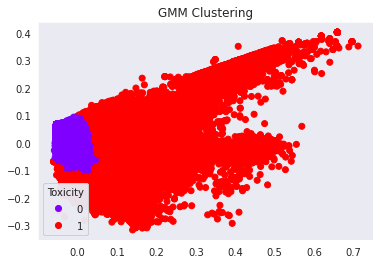

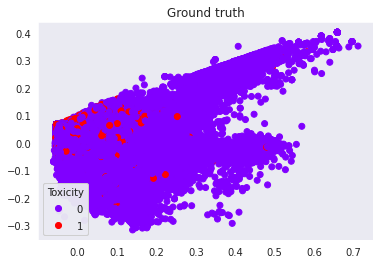

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
scatter = ax.scatter(xs, ys, c=clusters_gm, cmap='rainbow')
plt.title("GMM Clustering")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Toxicity")
ax.add_artist(legend1)

fig, ax = plt.subplots()
scatter = ax.scatter(xs, ys, c=train['toxic'], cmap='rainbow')
plt.title("Ground truth")
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Toxicity")
ax.add_artist(legend1)
plt.show()

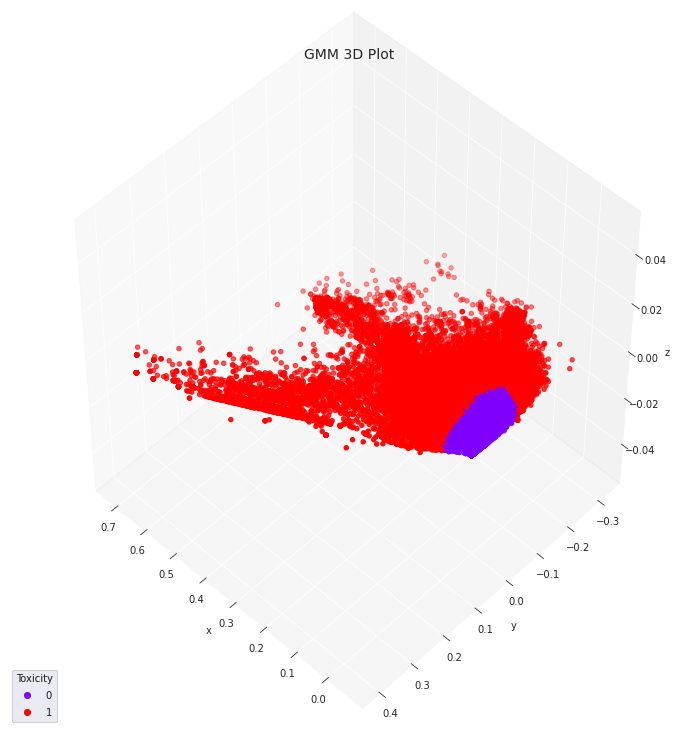

In [43]:
pca = PCA(n_components=2)
xgs = pca.fit_transform(comment_svd)[:,0]
ygs = pca.fit_transform(comment_svd)[:,1]


from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
scatter = ax.scatter(xgs, ygs, c=clusters_gm, cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("GMM 3D Plot", fontsize=14)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Toxicity")
ax.add_artist(legend1)

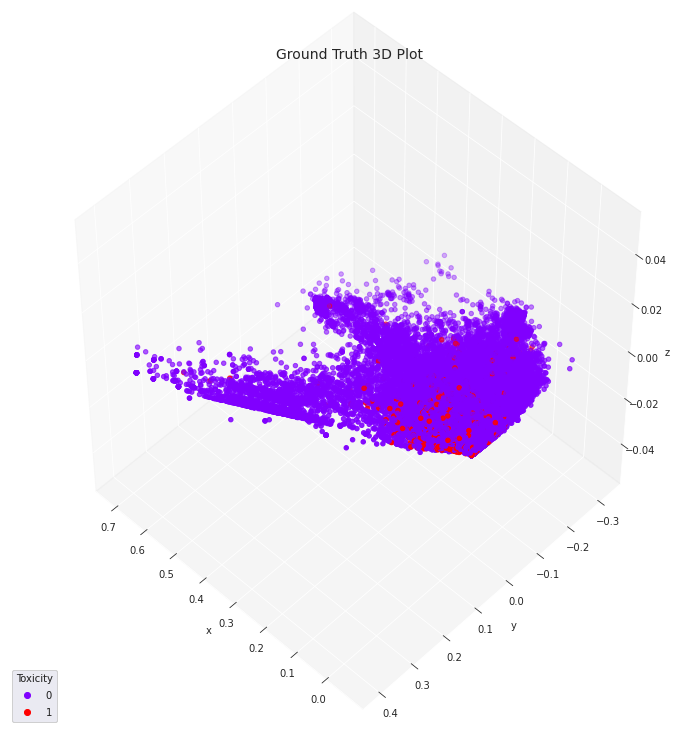

In [44]:
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
scatter = ax.scatter(xgs, ygs, c=train['toxic'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("Ground Truth 3D Plot", fontsize=14)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Toxicity")
ax.add_artist(legend1)

In [45]:
#labels
print(comment_svd.shape)
gm.means_

(159571, 2)


array([[ 0.0632035 , -0.02784239],
       [ 0.18232361,  0.04013377]])

**Performance metrics:**

In [46]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import fowlkes_mallows_score

In [47]:
print('gmm f1 score: ', f1_score(train['toxic'], clusters_gm))
print('gmm Accuracy: ', accuracy_score(train['toxic'], clusters_gm))
print('gmm FMM score: ', fowlkes_mallows_score(train['toxic'], clusters_gm))

gmm f1 score:  0.06307798481711527
gmm Accuracy:  0.7447656529068565
gmm FMM score:  0.7538049760243715


# Hierarchical Clustering

In [48]:
from sklearn.cluster import AgglomerativeClustering
n = len(comment_svd)
comm_idxs = np.random.choice(n, size=20000, replace=False)
cluster_h = AgglomerativeClustering(n_clusters=2,affinity="euclidean").fit_predict(comment_svd[comm_idxs])

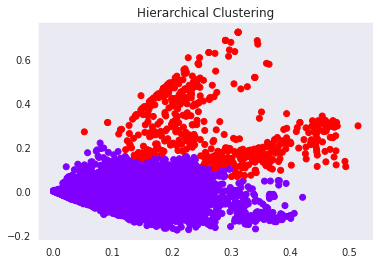

In [55]:
x_plot = comment_svd[comm_idxs]
x_plot = x_plot[:, 0]
y_plot = comment_svd[comm_idxs][:, 1]
plt.title("Hierarchical Clustering")
plt.scatter(x_plot, y_plot, c=cluster_h, cmap='rainbow')

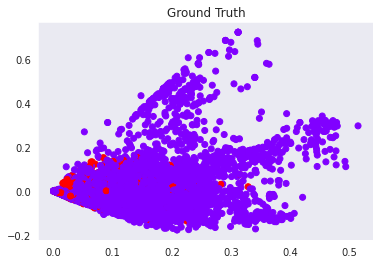

In [58]:
plt.title("Ground Truth")
plt.scatter(x_plot, y_plot, c=train['toxic'][comm_idxs], cmap='rainbow')

Performance Metrics

In [59]:
print('Hierarchical f1 score: ', f1_score(train['toxic'][comm_idxs], cluster_h))
print('Hierarchical Accuracy: ', accuracy_score(train['toxic'][comm_idxs], cluster_h))
print('Hierarchical FMM score: ', fowlkes_mallows_score(train['toxic'][comm_idxs], cluster_h))

Hierarchical f1 score:  0.0015313935681470136
Hierarchical Accuracy:  0.8696
Hierarchical FMM score:  0.8736699488561999
